Epoch 1/150


C:\Users\PP\miniconda3\envs\Ai_lab\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7479 - loss: 0.6623 - val_accuracy: 0.7917 - val_loss: 0.4412
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7729 - loss: 0.4726 - val_accuracy: 0.8083 - val_loss: 0.3965
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8062 - loss: 0.3991 - val_accuracy: 0.7833 - val_loss: 0.3813
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8229 - loss: 0.3845 - val_accuracy: 0.8000 - val_loss: 0.3897
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8021 - loss: 0.3764 - val_accuracy: 0.7750 - val_loss: 0.3994
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8250 - loss: 0.3551 - val_accuracy: 0.7833 - val_loss: 0.3983
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8271 - loss: 0.3503 - val_accuracy: 0.8000 - val_loss: 0.3958
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8500 - loss: 0.3449 - val_accuracy: 0.8083 - val_loss: 0.3958
Epoc

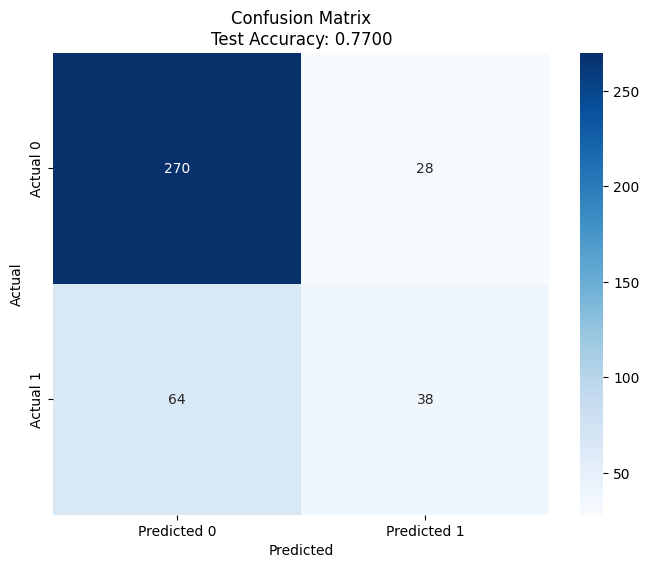

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # เพิ่ม seaborn สำหรับทำ Heatmap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix # เพิ่ม confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.utils import class_weight

# 0. Parameter ปรับแต่งได้ตรงนี้
LEARNING_RATE = 0.1
MAX_EPOCHS = 150
BATCH_SIZE = 128
THREADHOLD = 0.5
HIDDEN_UNITS_L1 = 16
HIDDEN_UNITS_L2 = 16
# 1. เตรียมข้อมูล (ใช้ไฟล์เดิมของคุณ)
df = pd.read_csv('updated_cleaned_patient_data.csv')
df = df.fillna(df.mean())
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- ส่วนที่ 2: สร้างและเทรนโมเดล (ปรับปรุงใหม่) ---
model = models.Sequential([
    layers.Dense(HIDDEN_UNITS_L1, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(HIDDEN_UNITS_L1, activation='sigmoid'),
    # เปลี่ยนจาก 1 (sigmoid) เป็น 2 (softmax)
    layers.Dense(2, activation='sigmoid') 
])

# เปลี่ยน loss เป็น sparse_categorical_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=40,            # ถ้า Val Loss ไม่ดีขึ้นติดต่อกัน 10 รอบ ให้หยุด
    restore_best_weights=True # ดึงค่าที่ดีที่สุดมาใช้
)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
#class_weights = dict(enumerate(weights))

#print(f"Class weights: {class_weights}")
# ตอนสั่ง fit ให้ใส่ callbacks เข้าไปด้วย
history = model.fit(
    X_train, y_train, 
    epochs=MAX_EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    callbacks=[early_stop], # เพิ่มบรรทัดนี้
    verbose=1
)

# --- ส่วนที่ 3: การประเมินผล (ปรับปรุงวิธีหา y_pred) ---

# ใช้ np.argmax เพื่อเลือกคลาสที่มีความน่าจะเป็นสูงสุด (0 หรือ 1)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) 

# หลังจากนี้ใช้โค้ดเดิมในการสร้าง Confusion Matrix ได้เลยครับ

# --- ส่วนที่ 1: พิมพ์ Classification Report (ตารางค่าสถิติ) ---
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred))
print("="*60)

# --- ส่วนที่ 2: วาด Confusion Matrix (ตารางความร้อนแบบในรูป) ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

# ใช้ Seaborn วาด Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

# ตกแต่งหัวข้อและแกน (ตามรูปที่คุณส่งมา)
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
plt.title(f'Confusion Matrix\nTest Accuracy: {test_accuracy:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

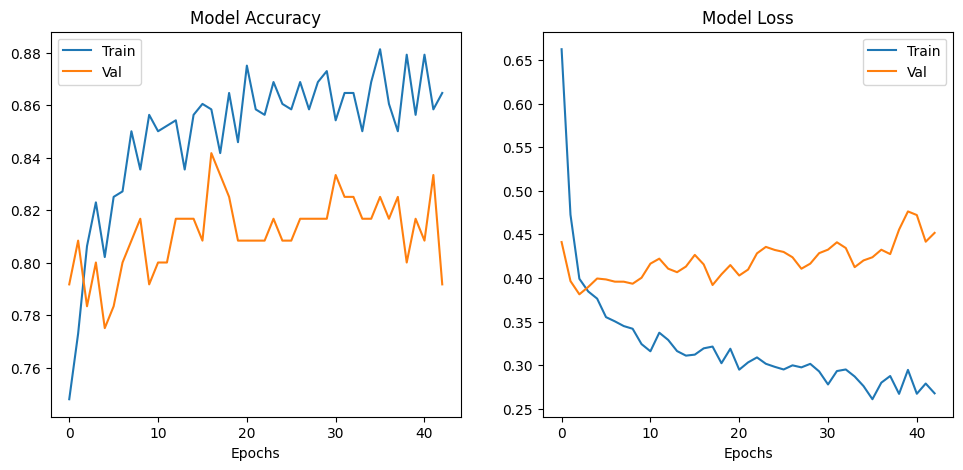

In [4]:


# --- พล็อต กราฟ 3 ส่วน (Loss, Accuracy, Confusion Matrix) ---
plt.figure(figsize=(18, 5))

# กราฟ Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.legend()

# กราฟ Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.legend()